In [20]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
import chromedriver_binary
from bs4 import BeautifulSoup
from credential import *
import json
import time
import pandas as pd
import re
import requests
import os
from IPython.display import display, HTML, Image
from tqdm.auto import tqdm
from copy import copy


options = webdriver.ChromeOptions()
options.add_argument("--headless=new")
options.add_argument("--window-size=1920,5400")

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36 Edg/117.0.2045.60",
}

folder_prefix = "nature-10.1038"

In [2]:
def to_institute(url):
    protocol, domain_and_path = url.split("://")
    domain, path = domain_and_path.split("/", 1)
    institute_domain = domain.replace(".", "-")
    institute_url = f"{protocol}://{institute_domain}.proxy.lib.ohio-state.edu/{path}"
    return institute_url


def to_normal(url):
    protocol, domain_and_path = url.split("://")
    domain, path = domain_and_path.split("/", 1)
    normal_domain = domain.replace(".proxy.lib.ohio-state.edu", "").replace("-", ".")
    normal_url = f"{protocol}://{normal_domain}/{path}"
    return normal_url


def maintext_formatter(article):
    for i in article.find_all("h2"):
        i.string = "\n\n" + i.text + ":\n"
    for i in article.find_all("h3"):
        i.string = "\n\n" + i.text + ":\n"
    for i in article.find_all("p"):
        i.append(" ")
    return re.sub(r"^ +", "", article.text, flags=re.MULTILINE).strip()

In [3]:
metadata_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQ6zCX7UhgM9Q7O9gp8IaAFwOfotCT7_jSbJc8ab0IY-Pmnf1fNOpVwnAG-Jn_WVdP1XKRHntDxHIBU/pub?gid=101839528&single=true&output=csv"
df_meta = pd.read_csv(metadata_url)

In [4]:
exclude_list = [
    "10.1038/s41567-022-01788-5",
]
nature_list = [
    i
    for i in df_meta[
        df_meta.isPaper & df_meta.hasHtml & (df_meta.platform == "Nature")
    ].doi.tolist()
    if i not in exclude_list
]
nature_list

['10.1038/nature24270',
 '10.1038/nature16961',
 '10.1038/nature16961',
 '10.1038/s41586-021-03819-2',
 '10.1038/s41586-021-03819-2',
 '10.1038/s41586-021-03819-2',
 '10.1038/s41586-023-06004-9',
 '10.1038/s43247-021-00179-7',
 '10.1038/s41586-019-1724-z',
 '10.1038/s41586-020-03051-4',
 '10.1038/s41598-019-41895-7',
 '10.1038/nature14236',
 '10.1038/s41586-019-1799-6',
 '10.1038/nature14422',
 '10.1038/s41591-018-0107-6',
 '10.1038/srep21471']

In [21]:
driver = webdriver.Chrome(options=options)
errors = []
processed = []

for doi in tqdm(nature_list[:]):
    if doi in processed:
        continue

    paper_id = doi.split("/")[-1]
    os.makedirs(f"{folder_prefix}/{paper_id}", exist_ok=True)
    url = to_institute(f"https://doi.org/{doi}")

    driver.get(url)
    try:
        WebDriverWait(driver, timeout=10).until(
            lambda d: "Login Required" in d.page_source
            or d.find_element(By.CLASS_NAME, "c-article-body").is_displayed()
        )
    except Exception as e:
        errors.append((f"{url}: Invalid URL", e, driver.get_screenshot_as_png()))
        continue
    if "Login Required" in driver.page_source:
        print(f"OSU proxy login required.")
        username_element = driver.find_element(By.ID, "username")
        password_element = driver.find_element(By.ID, "password")
        username_element.send_keys(osu_username)
        password_element.send_keys(osu_passwd)
        login_button = driver.find_element(By.ID, "submit")
        login_button.click()
        print(f"OSU proxy login success.")
    try:
        WebDriverWait(driver, timeout=10).until(
            lambda d: d.find_element(By.CLASS_NAME, "c-article-body").is_displayed()
        )
    except Exception as e:
        errors.append((f"{url}: Article not found", e, driver.get_screenshot_as_png()))
        continue

    soup = BeautifulSoup(driver.page_source, "html.parser")
    with open(f"{folder_prefix}/{paper_id}/webpage.html", "w") as f:
        f.write(soup.prettify())
    meta_match = re.search(
        r"(?<=<script type=\"application/ld\+json\">)\s*\{.+\}\s*(?=</script>)",
        str(soup),
    )
    if meta_match:
        meta = json.loads(meta_match.group(0))
        with open(f"{folder_prefix}/{paper_id}/meta.json", "w") as f:
            json.dump(meta, f, indent=4)
    else:
        errors.append((f"{url}: No metadata found", driver.get_screenshot_as_png()))

    try:
        abstract = soup.find("section", {"data-title": "Abstract"}).find("p").text
        with open(f"{folder_prefix}/{paper_id}/abstract.txt", "w") as f:
            f.write(abstract)
    except Exception as e:
        errors.append((f"{url}: No abstract found", e, driver.get_screenshot_as_png()))

    article = soup.find("div", {"class": "main-content"})

    figures = article.find_all("div", {"data-container-section": "figure"})
    for fig in figures:
        img_url = to_normal(
            "https:" + re.sub(r"(?<=/)lw\d{3,4}(?=/)", "full", fig.find("img")["src"])
        )
        img_name = img_url.split("/")[-1]
        imgb = requests.get(img_url, headers=headers).content
        fig_id = fig["id"].replace("ure-", "")
        with open(f"{folder_prefix}/{paper_id}/{fig_id}-{img_name}", "wb") as f:
            f.write(imgb)
        if fig.find("p"):
            fig_caption = fig.find("p").text
            with open(f"{folder_prefix}/{paper_id}/{fig_id}-caption.txt", "w") as f:
                f.write(fig_caption)
            fig.find("div", {"class": "u-text-right u-hide-print"}).extract()

    tables = article.find_all("div", {"data-container-section": "table"})
    for tab in tables:
        tab_id = tab["id"].replace("-", "")
        tab_url = (
            "https://www.nature.com"
            + tab.find("a", {"data-test": "table-link"})["href"]
        )
        driver.get(tab_url)
        try:
            WebDriverWait(driver, timeout=10).until(
                lambda d: d.find_element(
                    By.CLASS_NAME, "c-article-table-container"
                ).is_displayed()
            )
            tab_soup = BeautifulSoup(driver.page_source, "html.parser")
            if len(driver.find_elements(By.CLASS_NAME, "data.last-table")) > 0:
                tab_source = tab_soup.find("table", {"class": "data last-table"})
                with open(f"{folder_prefix}/{paper_id}/{tab_id}-source.html", "w") as f:
                    f.write(tab_source.prettify())
                tab_element = driver.find_element(
                    By.CLASS_NAME, "c-article-table-border.c-table-scroll-wrapper"
                )
                driver.execute_script("arguments[0].scrollIntoView(true);", tab_element)
                tab_element.screenshot(
                    f"{folder_prefix}/{paper_id}/{tab_id}-screenshot.png"
                )
            elif len(driver.find_elements(By.CLASS_NAME, "c-article-table-image")):
                tab_img_url = to_normal(
                    "https:"
                    + re.sub(
                        r"(?<=/)lw\d{3,4}(?=/)",
                        "full",
                        tab_soup.find("div", {"class": "c-article-table-image"}).find(
                            "img"
                        )["src"],
                    )
                )
                tab_imgb = requests.get(tab_img_url, headers=headers).content
                with open(
                    f"{folder_prefix}/{paper_id}/{tab_id}-screenshot.png", "wb"
                ) as f:
                    f.write(tab_imgb)
            else:
                errors.append(
                    (
                        f"{tab_url}: Unrecognized table structure",
                        e,
                        driver.get_screenshot_as_png(),
                    )
                )
            tab_caption = tab.find("b").text
            with open(f"{folder_prefix}/{paper_id}/{tab_id}-caption.txt", "w") as f:
                f.write(tab_caption)
            tab.find("div", {"class": "u-text-right u-hide-print"}).extract()
        except Exception as e:
            errors.append(
                (
                    f"{tab_url}: Can't access table url",
                    e,
                    driver.get_screenshot_as_png(),
                )
            )

    with open(f"{folder_prefix}/{paper_id}/maintext.txt", "w") as f:
        f.write(maintext_formatter(article))

    processed.append(doi)

driver.close()
print(f"Scraped {len(processed)} papers")
print(f"Errors: {len(errors)}")
for l, e, s in errors:
    print(l)
    # print(e)
    # display(Image(s))
    # time.sleep(0.1)

  0%|          | 0/16 [00:00<?, ?it/s]

Login Required
Scraped 13 papers
Errors: 0


In [18]:
soup.find("section", {"data-title": "Abstract"}).find("p").text

'The theory of reinforcement learning provides a normative account1, deeply rooted in psychological2 and neuroscientific3 perspectives on animal behaviour, of how agents may optimize their control of an environment. To use reinforcement learning successfully in situations approaching real-world complexity, however, agents are confronted with a difficult task: they must derive efficient representations of the environment from high-dimensional sensory inputs, and use these to generalize past experience to new situations. Remarkably, humans and other animals seem to solve this problem through a harmonious combination of reinforcement learning and hierarchical sensory processing systems4,5, the former evidenced by a wealth of neural data revealing notable parallels between the phasic signals emitted by dopaminergic neurons and temporal difference reinforcement learning algorithms3. While reinforcement learning agents have achieved some successes in a variety of domains6,7,8, their applicab

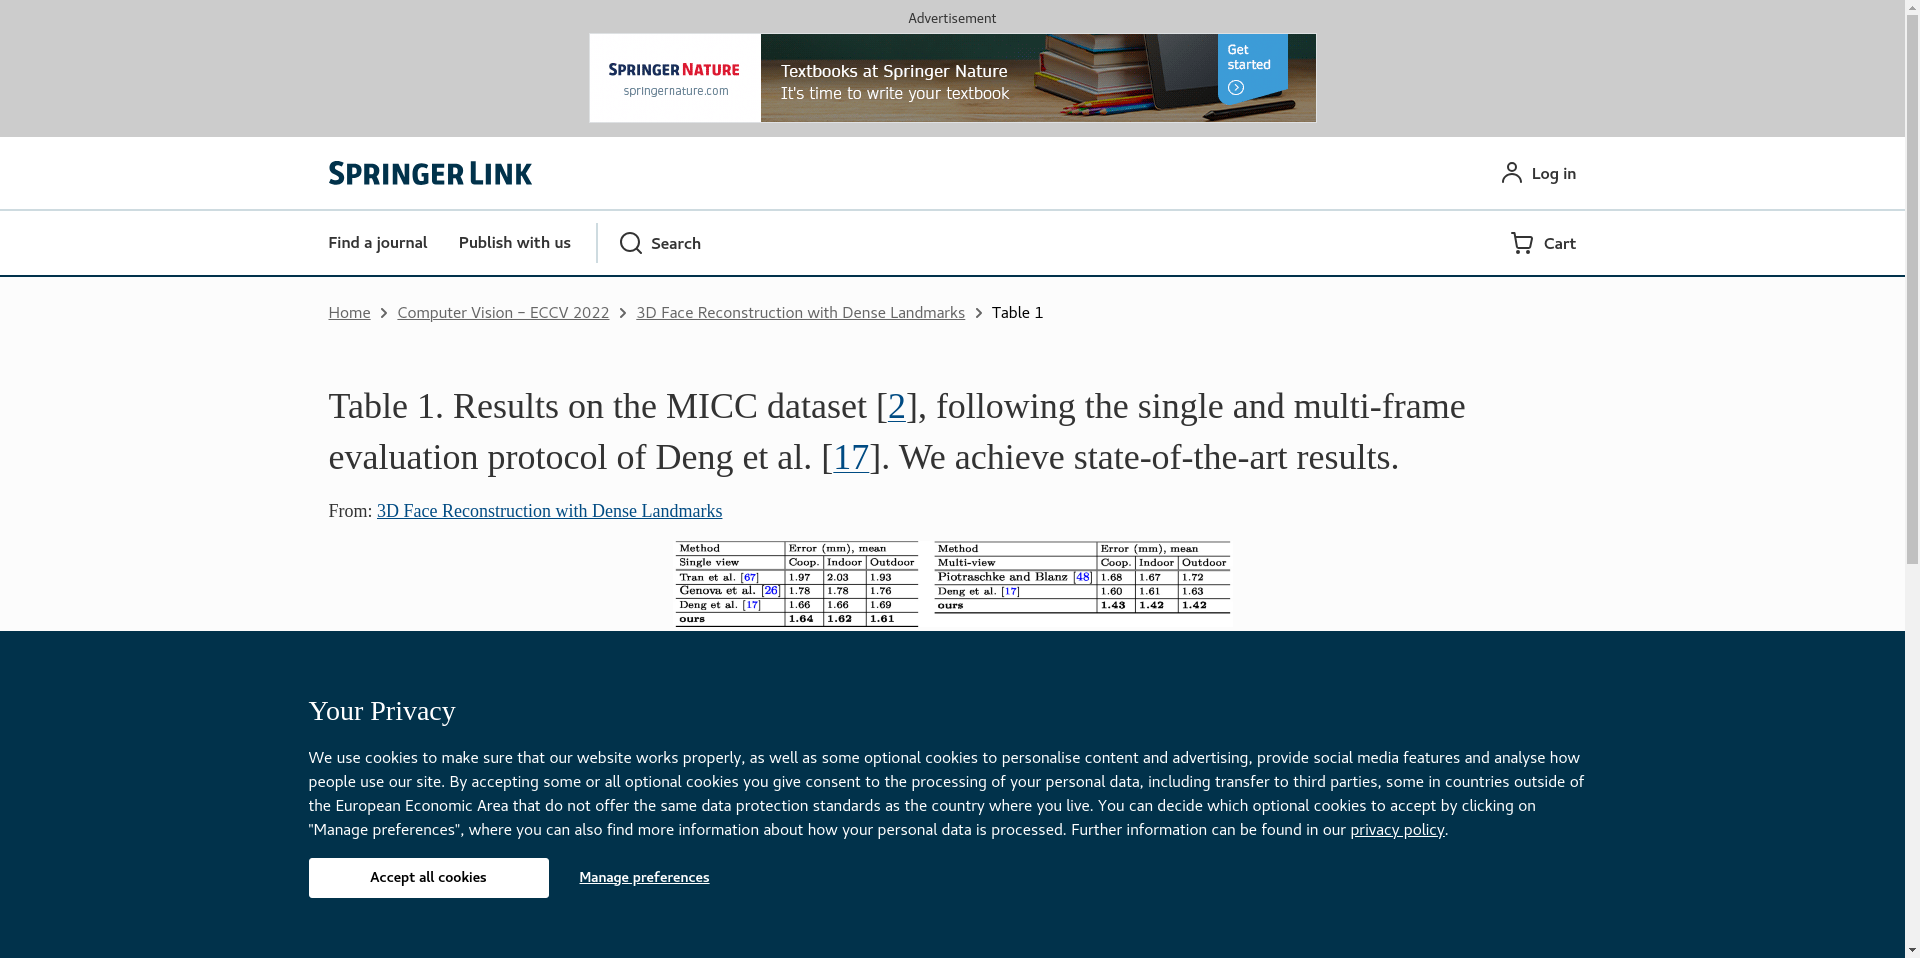

In [ ]:
display(Image(driver.get_screenshot_as_png()))